# Notebook d'exploration Stanford dogs dataset
## Adrian Rodriguez
## Projet 6 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Classez-des-images-l-aide-d-algorithmes-de-Deep-Learning  
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Vous êtes bénévole pour l'association de protection des animaux de votre quartier. C'est d'ailleurs ainsi que vous avez trouvé votre compagnon idéal, Snooky. Vous vous demandez donc ce que vous pouvez faire en retour pour aider l'association.

Vous apprenez, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc obtenir un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.

## Les données
Les bénévoles de l'association n'ont pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs. Pas de problème, vous entraînerez votre algorithme en utilisant le Stanford Dogs Dataset.

## Votre mission
L'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

Vous avez peu d’expérience sur le sujet, vous décidez donc de contacter un ami expert en classification d’images.

Il vous conseille dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).

Ensuite, il vous incite à mettre en œuvre deux approches s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels), que vous comparerez en termes de temps de traitement et de résultat :

* Une première en réalisant votre propre réseau CNN, en vous inspirant de réseaux CNN existants. Prenez soin d'optimiser certains hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)
* Une deuxième en utilisant le transfer learning, c’est-à-dire en utilisant un réseau déjà entraîné, et en le modifiant pour répondre à votre problème.

Concernant le transfer learning, votre ami vous précise que :

* Une première chose obligatoire est de réentraîner les dernières couches pour prédire les classes qui vous intéressent seulement.
* Il est également possible d’adapter la structure (supprimer certaines couches, par exemple) ou de réentraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

## Ressources de calcul
Votre ami vous alerte sur le fait que l'entraînement (même partiel) d'un réseau de neurones convolutionnels est très gourmand en ressources. Si le processeur de l’ordinateur un peu ancien de l’association ne suffit pas, il vous propose plusieurs solutions :

* Limitez le jeu de données, en ne sélectionnant que quelques classes (races de chiens), ce qui permettra déjà de tester la démarche et la conception des modèles, avant une éventuelle généralisation.
* Utilisez la carte graphique de l’ordinateur en tant que GPU (l'installation est un peu fastidieuse, et l'ordinateur est inutilisable le temps du calcul).

Ce notebook explore l'état de la classification SIFT, qui servait avant l'arrivée des réseaux CNN.

In [1]:
import pandas as pd
import numpy as np
import cv2 as cv

import seaborn as sns
import matplotlib.pyplot as plt

from skimage.restoration import denoise_tv_chambolle
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

from functions_dl import *

---
# 1. Import des donnnées

In [2]:
# Paramètrage
n_breeds = 5
size_image = 'original'

In [3]:
if size_image == 'original':
    dogs_raw = pd.read_csv('src/dogs.csv')
elif size_image == '220px':
    dogs_raw = pd.read_csv('src/dogs220.csv')

dogs_raw

,uri,breeds
0,src\img\n02085620-Chihuahua\n02085620_10074.jpg,Chihuahua
1,src\img\n02085620-Chihuahua\n02085620_10131.jpg,Chihuahua
2,src\img\n02085620-Chihuahua\n02085620_10621.jpg,Chihuahua
3,src\img\n02085620-Chihuahua\n02085620_1073.jpg,Chihuahua
4,src\img\n02085620-Chihuahua\n02085620_10976.jpg,Chihuahua
...,...,...
20574,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog
20575,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog
20576,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog
20577,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog


In [4]:
print(f'Nous avons {len(dogs_raw)} photos de chiens comprenant {dogs_raw.breeds.nunique()} races.')

Nous avons 20579 photos de chiens comprenant 120 races.


---
# 2. Réduction des données aux nombres de races testées

In [5]:
top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
top_breeds

['Maltese_dog', 'Afghan_hound', 'Scottish_deerhound', 'Pomeranian', 'Samoyed']

In [6]:
dogs = pd.DataFrame()
for b in top_breeds:
    dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

dogs

,uri,breeds
337,src\img\n02085936-Maltese_dog\n02085936_10073.jpg,Maltese_dog
338,src\img\n02085936-Maltese_dog\n02085936_10130.jpg,Maltese_dog
339,src\img\n02085936-Maltese_dog\n02085936_10148.jpg,Maltese_dog
340,src\img\n02085936-Maltese_dog\n02085936_10197.jpg,Maltese_dog
341,src\img\n02085936-Maltese_dog\n02085936_10199.jpg,Maltese_dog
...,...,...
18417,src\img\n02111889-Samoyed\n02111889_899.jpg,Samoyed
18418,src\img\n02111889-Samoyed\n02111889_9001.jpg,Samoyed
18419,src\img\n02111889-Samoyed\n02111889_91.jpg,Samoyed
18420,src\img\n02111889-Samoyed\n02111889_928.jpg,Samoyed


In [7]:
# Encodage des données cibles
le = LabelEncoder()
dogs['encoding_breeds'] = le.fit_transform(dogs.breeds)
dogs

,uri,breeds,encoding_breeds
337,src\img\n02085936-Maltese_dog\n02085936_10073.jpg,Maltese_dog,1
338,src\img\n02085936-Maltese_dog\n02085936_10130.jpg,Maltese_dog,1
339,src\img\n02085936-Maltese_dog\n02085936_10148.jpg,Maltese_dog,1
340,src\img\n02085936-Maltese_dog\n02085936_10197.jpg,Maltese_dog,1
341,src\img\n02085936-Maltese_dog\n02085936_10199.jpg,Maltese_dog,1
...,...,...,...
18417,src\img\n02111889-Samoyed\n02111889_899.jpg,Samoyed,3
18418,src\img\n02111889-Samoyed\n02111889_9001.jpg,Samoyed,3
18419,src\img\n02111889-Samoyed\n02111889_91.jpg,Samoyed,3
18420,src\img\n02111889-Samoyed\n02111889_928.jpg,Samoyed,3


In [8]:
X_train, X_test, y_train, y_test = train_test_split(dogs.uri, dogs.encoding_breeds, test_size=0.2, random_state=42)

---
# 3. Descripteurs SIFT


## 3-1. Descripteurs SIFT

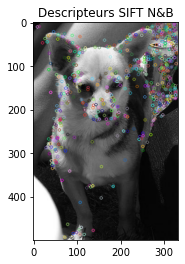

In [9]:
img1 = cv.imread(dogs_raw.uri[0])  
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)

#keypoints
sift = cv.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)

img_1 = cv.drawKeypoints(gray1,keypoints_1,img1)
plt.imshow(img_1)
plt.title("Descripteurs SIFT N&B")
plt.savefig('img/sift_descriptors_N&B.png', transparent=True)

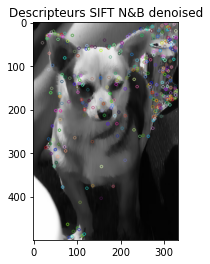

In [10]:
# Réduction du bruit
denoised_img = denoise_tv_chambolle(gray1, weight=0.1, multichannel=True)
# Conversion en 8 bit
img8bit = cv.normalize(denoised_img,
                        None,
                        0,
                        255,
                        cv.NORM_MINMAX).astype('uint8')

#keypoints
sift = cv.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img8bit,None)

img_1 = cv.drawKeypoints(img8bit,keypoints_1,img1)
plt.imshow(img_1)
plt.title("Descripteurs SIFT N&B denoised")
plt.savefig('img/sift_descriptors_N&B_denoised.png', transparent=True)

## 3-2. Extractions des descripteurs 
Pour l'extraction des descripteurs, la fonction ```get_sift_features``` procède à 2 transformations :
- Transformation de l'image en noir et blanc.
- Suppression du bruit afin de se limiter aux descripteurs essentiels.

In [11]:
%time descriptor_list = get_sifts_features(X_train)
print(f"Nous avons {len(descriptor_list)} descripteurs dans le jeu d'entrainement ({len(X_train)} photos)")

Wall time: 19min 35s
Nous avons 589022 descripteurs dans le jeu d'entrainement (928 photos)


## 3.3 Réduction des descripteurs

In [12]:
# Pour optimiser les temps de calculs, je procède à un kmeans mini batch.
# Le batch vaut 10 % de la liste des descripteur
batch_size = int(len(descriptor_list) * 0.1)
print(f'Minibatch pour kmeans = {batch_size}')

Minibatch pour kmeans = 58902


In [11]:
# Méthode visuelle
Sum_of_squared_distances = []
K = np.arange(100, 1000, 100)
for k in K:
    print(f"{k} clusters en cours d'entraînement...")
    km = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
    km = km.fit(descriptor_list)
    Sum_of_squared_distances.append(km.inertia_)

plt.clf()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - ' + str(size_image) + ' ' + str(n_breeds) + ' breeds' )

plt.savefig('img/sift_elbow_kmeans_' + str(size_image) + '_' + str(n_breeds) + '_breeds.png',
            transparent=True)

100 clusters en cours d'entraînement...
200 clusters en cours d'entraînement...
300 clusters en cours d'entraînement...
400 clusters en cours d'entraînement...
500 clusters en cours d'entraînement...
600 clusters en cours d'entraînement...


In [11]:
k = 300
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
%time kmeans.fit(descriptor_list)

Wall time: 2min 12s


MiniBatchKMeans(batch_size=58902, compute_labels=True, init=&#39;k-means++&#39;,
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=300, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

## 3-4. Obtention des mots visuels

In [12]:
%time bovw_train = get_vector_sift(X_train, kmeans, k)
bovw_train

Wall time: 9min 54s


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.0,1.0,2.0,3.0,1.0,4.0,2.0,2.0,0.0,5.0,...,1.0,2.0,0.0,1.0,4.0,3.0,3.0,2.0,0.0,3.0
1,5.0,0.0,3.0,0.0,5.0,1.0,3.0,18.0,1.0,2.0,...,1.0,4.0,1.0,2.0,3.0,0.0,6.0,0.0,0.0,0.0
2,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4.0,2.0,4.0,0.0,0.0,0.0
3,11.0,8.0,4.0,12.0,10.0,1.0,4.0,2.0,4.0,8.0,...,8.0,5.0,9.0,5.0,1.0,9.0,10.0,7.0,15.0,9.0
4,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,1.0,4.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,26.0,0.0,0.0,0.0
924,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0
925,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0
926,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0


In [13]:
%time bovw_test = get_vector_sift(X_test, kmeans, k)
bovw_test

Wall time: 2min 26s


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,2.0,1.0,4.0,3.0,0.0,1.0,6.0,3.0,4.0,5.0,...,1.0,2.0,0.0,4.0,1.0,4.0,4.0,1.0,3.0,1.0
1,0.0,0.0,4.0,0.0,0.0,1.0,0.0,8.0,4.0,0.0,...,0.0,4.0,0.0,0.0,3.0,0.0,10.0,0.0,0.0,0.0
2,0.0,3.0,4.0,3.0,2.0,2.0,5.0,1.0,1.0,1.0,...,4.0,1.0,2.0,2.0,5.0,2.0,5.0,2.0,3.0,3.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,6.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0
228,0.0,2.0,2.0,1.0,4.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,3.0,1.0,3.0,3.0,4.0,1.0,2.0,0.0
229,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,1.0
230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


---
# 4. Classification

LogisticRegression en cours d&#39;exécution...
LinearSVC en cours d&#39;exécution...
SGD en cours d&#39;exécution...
RandomForest en cours d&#39;exécution...
GradientBoosting en cours d&#39;exécution...


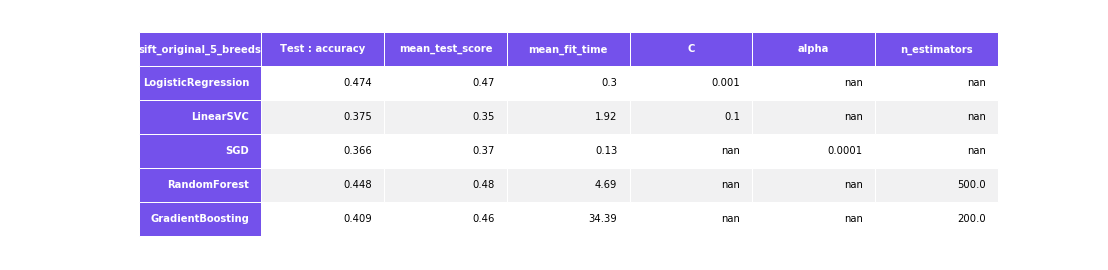

Wall time: 3min 2s


In [14]:
# To Do : Tester Random Forest et Gradient boosting
classifiers = [('LogisticRegression',
                LogisticRegression(),
                [{'C': [0.001, 0.1, 1]}]),

              ('LinearSVC',
               LinearSVC(),
               [{'C': [00.1, 0.1, 1]}]), 

              ('SGD',
               SGDClassifier(),
               [{'alpha': [10**-6, 10**-5, 10**-4]}]),
               
              ('RandomForest',
               RandomForestClassifier(random_state=123),
               [{'n_estimators': [200, 500, 1000]}]),

              ('GradientBoosting', 
               GradientBoostingClassifier(random_state=123), 
               [{'n_estimators': [200, 500, 1000]}])]

%time evaluate_classifier(bovw_train, bovw_test, y_train, y_test, classifiers, target_name='sift_' + str(size_image) + '_' + str(n_breeds) + '_breeds')

La régression logisitique a les meilleurs résultats sur les données de test. Ce sera mon modèle final.

In [17]:
model = LogisticRegression(C=0.001, n_jobs=-1)
model.fit(bovw_train, y_train)
y_pred = model.predict(bovw_test)

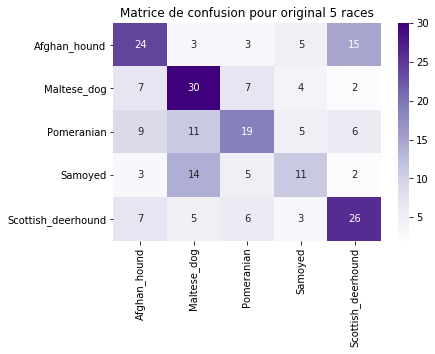

In [18]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Matrice de confusion pour ' + str(size_image) + ' ' + str(n_breeds) + ' races')
plt.savefig('img/sift_confusion_matrix' + str(size_image) + '_' + str(n_breeds) + '_breeds.png',
            transparent=True,
            bbox_inches="tight")

---
# 5. Evaluation sur les images 220 px et 5 races de chiens

[&#39;Maltese_dog&#39;, &#39;Afghan_hound&#39;, &#39;Scottish_deerhound&#39;, &#39;Pomeranian&#39;, &#39;Samoyed&#39;]
Wall time: 3min 26s
Nous avons 185174 descripteurs dans le jeu d&#39;entrainement (928 photos)
18517
100
200
300
400
500
600
700
800
900


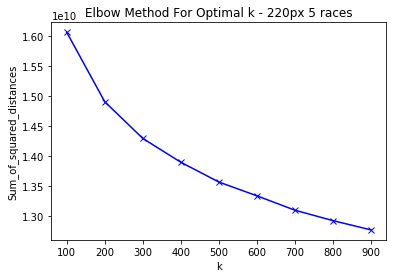

In [5]:
# Paramètrage
n_breeds = 5
size_image = '220px'

# Lecture des données
if size_image == 'original':
    dogs_raw = pd.read_csv('src/dogs.csv')
elif size_image == '220px':
    dogs_raw = pd.read_csv('src/dogs220.csv')

top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
print(top_breeds)

dogs = pd.DataFrame()
for b in top_breeds:
    dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

# Encodage des données cibles
le = LabelEncoder()
dogs['encoding_breeds'] = le.fit_transform(dogs.breeds)

# Split
X_train, X_test, y_train, y_test = train_test_split(dogs.uri, dogs.encoding_breeds, test_size=0.2, random_state=42)

# Calcul des descripteurs
%time descriptor_list = get_sifts_features(X_train)
print(f"Nous avons {len(descriptor_list)} descripteurs dans le jeu d'entrainement ({len(X_train)} photos)")

# Réduction de dimension
# Pour optimiser les temps de calculs, je procède à un kmeans mini batch.
# Le batch vaut 10 % de la liste des descripteur
batch_size = int(len(descriptor_list) * 0.1)
print(f'Minibatch pour kmeans = {batch_size}')

# Méthode visuelle
Sum_of_squared_distances = []
K = np.arange(100, 1000, 100)
for k in K:
    print(f"{k} clusters en cours d'entraînement...")
    km = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
    km = km.fit(descriptor_list)
    Sum_of_squared_distances.append(km.inertia_)

plt.clf()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - ' + str(size_image) + ' ' + str(n_breeds) + ' breeds' )

plt.savefig('img/sift_elbow_kmeans_' + str(size_image) + '_' + str(n_breeds) + '_breeds.png',
            transparent=True)

Choix du nombre de clusters : 300

Wall time: 29.3 s
Wall time: 3min 59s
Wall time: 1min 3s
LogisticRegression en cours d&#39;exécution...
LinearSVC en cours d&#39;exécution...
SGD en cours d&#39;exécution...
RandomForest en cours d&#39;exécution...
GradientBoosting en cours d&#39;exécution...


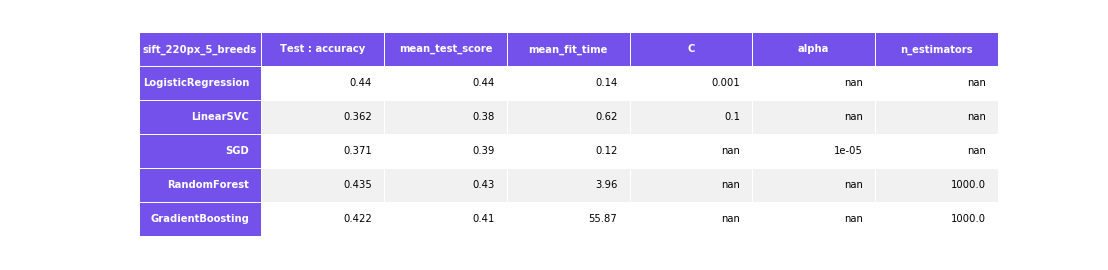

Wall time: 2min 33s


In [6]:
k = 300
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
%time kmeans.fit(descriptor_list)

%time bovw_train = get_vector_sift(X_train, kmeans, k)
%time bovw_test = get_vector_sift(X_test, kmeans, k)


classifiers = [('LogisticRegression',
                LogisticRegression(),
                [{'C': [0.001, 0.1, 1]}]),

              ('LinearSVC',
               LinearSVC(),
               [{'C': [00.1, 0.1, 1]}]), 

              ('SGD',
               SGDClassifier(),
               [{'alpha': [10**-6, 10**-5, 10**-4]}]),
               
              ('RandomForest',
               RandomForestClassifier(random_state=123),
               [{'n_estimators': [200, 500, 1000]}]),

              ('GradientBoosting', 
               GradientBoostingClassifier(random_state=123), 
               [{'n_estimators': [200, 500, 1000]}])]

%time evaluate_classifier(bovw_train, bovw_test, y_train, y_test, classifiers, target_name='sift_' + str(size_image) + '_' + str(n_breeds) + '_breeds')

Les résultats sont légèrement moins précis, mais les temps de calcul sont considérablement réduite. Cela aura un aspece positif sur la maintenance. La réduction de la taille de l'image permet également aux méthodes ensembliste de moins être en surapprentissage.

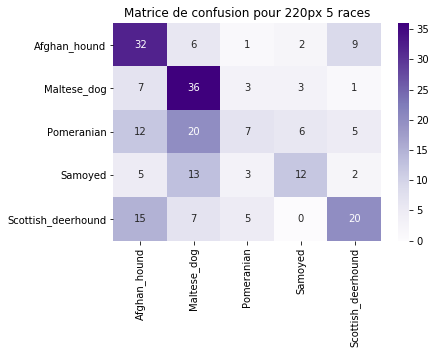

In [8]:
model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
model.fit(bovw_train, y_train)
y_pred = model.predict(bovw_test)


cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Matrice de confusion pour ' + str(size_image) + ' ' + str(n_breeds) + ' races')
plt.savefig('img/sift_confusion_matrix_' + str(size_image) + '_' + str(n_breeds) + '_breeds.png',
            transparent=True,
            bbox_inches="tight")

---
# 6. Evaluation sur les images 220 px et 2 races de chiens

[&#39;Maltese_dog&#39;, &#39;Afghan_hound&#39;]
Wall time: 2min 30s
Nous avons 81297 descripteurs dans le jeu d&#39;entrainement (392 photos)
Minibatch pour kmeans = 8129
100 clusters en cours d&#39;entraînement...
200 clusters en cours d&#39;entraînement...
300 clusters en cours d&#39;entraînement...
400 clusters en cours d&#39;entraînement...
500 clusters en cours d&#39;entraînement...
600 clusters en cours d&#39;entraînement...
700 clusters en cours d&#39;entraînement...
800 clusters en cours d&#39;entraînement...
900 clusters en cours d&#39;entraînement...


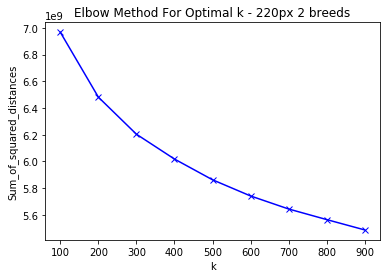

In [2]:
# Paramètrage
n_breeds = 2
size_image = '220px'

# Lecture des données
if size_image == 'original':
    dogs_raw = pd.read_csv('src/dogs.csv')
elif size_image == '220px':
    dogs_raw = pd.read_csv('src/dogs220.csv')

top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
print(top_breeds)

dogs = pd.DataFrame()
for b in top_breeds:
    dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

# Encodage des données cibles
le = LabelEncoder()
dogs['encoding_breeds'] = le.fit_transform(dogs.breeds)

# Split
X_train, X_test, y_train, y_test = train_test_split(dogs.uri, dogs.encoding_breeds, test_size=0.2, random_state=42)

# Calcul des descripteurs
%time descriptor_list = get_sifts_features(X_train)
print(f"Nous avons {len(descriptor_list)} descripteurs dans le jeu d'entrainement ({len(X_train)} photos)")

# Réduction de dimension
# Pour optimiser les temps de calculs, je procède à un kmeans mini batch.
# Le batch vaut 10 % de la liste des descripteur
batch_size = int(len(descriptor_list) * 0.1)
print(f'Minibatch pour kmeans = {batch_size}')

# Méthode visuelle
Sum_of_squared_distances = []
K = np.arange(100, 1000, 100)
for k in K:
    print(f"{k} clusters en cours d'entraînement...")
    km = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
    km = km.fit(descriptor_list)
    Sum_of_squared_distances.append(km.inertia_)

plt.clf()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - ' + str(size_image) + ' ' + str(n_breeds) + ' breeds' )

plt.savefig('img/sift_elbow_kmeans_' + str(size_image) + '_' + str(n_breeds) + '_breeds.png',
            transparent=True)

Nombre de clusters : 300

Wall time: 23 s
Wall time: 3min 2s
Wall time: 44 s
LogisticRegression en cours d&#39;exécution...
LinearSVC en cours d&#39;exécution...
SGD en cours d&#39;exécution...
RandomForest en cours d&#39;exécution...
GradientBoosting en cours d&#39;exécution...


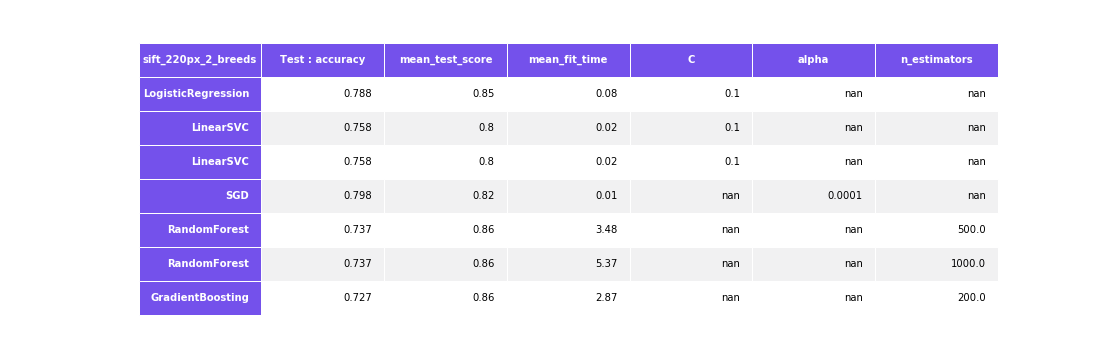

Wall time: 25.1 s


In [3]:
k = 300
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
%time kmeans.fit(descriptor_list)

%time bovw_train = get_vector_sift(X_train, kmeans, k)
%time bovw_test = get_vector_sift(X_test, kmeans, k)


classifiers = [('LogisticRegression',
                LogisticRegression(),
                [{'C': [0.001, 0.1, 1]}]),

              ('LinearSVC',
               LinearSVC(),
               [{'C': [00.1, 0.1, 1]}]), 

              ('SGD',
               SGDClassifier(),
               [{'alpha': [10**-6, 10**-5, 10**-4]}]),
               
              ('RandomForest',
               RandomForestClassifier(random_state=123),
               [{'n_estimators': [200, 500, 1000]}]),

              ('GradientBoosting', 
               GradientBoostingClassifier(random_state=123), 
               [{'n_estimators': [200, 500, 1000]}])]

%time evaluate_classifier(bovw_train, bovw_test, y_train, y_test, classifiers, target_name='sift_' + str(size_image) + '_' + str(n_breeds) + '_breeds')

Choix du modèle LogisticRegression(C=0.1, n_jobs=-1)

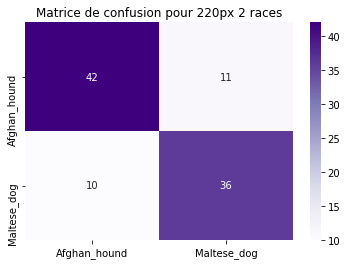

In [4]:
model = LogisticRegression(C=0.1, n_jobs=-1)
model.fit(bovw_train, y_train)
y_pred = model.predict(bovw_test)


cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Matrice de confusion pour ' + str(size_image) + ' ' + str(n_breeds) + ' races')
plt.savefig('img/sift_confusion_matrix_' + str(size_image) + '_' + str(n_breeds) + '_breeds.png',
            transparent=True,
            bbox_inches="tight")

---
# 7. Evaluation sur les images 220 px et 10 races de chiens

[&#39;Maltese_dog&#39;, &#39;Afghan_hound&#39;, &#39;Scottish_deerhound&#39;, &#39;Pomeranian&#39;, &#39;Samoyed&#39;, &#39;Bernese_mountain_dog&#39;, &#39;Irish_wolfhound&#39;, &#39;Shih-Tzu&#39;, &#39;Great_Pyrenees&#39;, &#39;Leonberg&#39;]
Wall time: 7min 28s
Nous avons 375386 descripteurs dans le jeu d&#39;entrainement (1786 photos)
37538
100
200
300
400
500
600
700
800
900


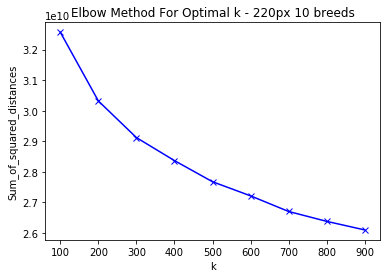

In [9]:
# Paramètrage
n_breeds = 10
size_image = '220px'

# Lecture des données
if size_image == 'original':
    dogs_raw = pd.read_csv('src/dogs.csv')
elif size_image == '220px':
    dogs_raw = pd.read_csv('src/dogs220.csv')

top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
print(top_breeds)

dogs = pd.DataFrame()
for b in top_breeds:
    dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

# Encodage des données cibles
le = LabelEncoder()
dogs['encoding_breeds'] = le.fit_transform(dogs.breeds)

# Split
X_train, X_test, y_train, y_test = train_test_split(dogs.uri, dogs.encoding_breeds, test_size=0.2, random_state=42)

# Calcul des descripteurs
%time descriptor_list = get_sifts_features(X_train)
print(f"Nous avons {len(descriptor_list)} descripteurs dans le jeu d'entrainement ({len(X_train)} photos)")

# Réduction de dimension
# Pour optimiser les temps de calculs, je procède à un kmeans mini batch.
# Le batch vaut 10 % de la liste des descripteur
batch_size = int(len(descriptor_list) * 0.1)
print(f'Minibatch pour kmeans = {batch_size}')

# Méthode visuelle
Sum_of_squared_distances = []
K = np.arange(100, 1000, 100)
for k in K:
    print(f"{k} clusters en cours d'entraînement...")
    km = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
    km = km.fit(descriptor_list)
    Sum_of_squared_distances.append(km.inertia_)

plt.clf()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - ' + str(size_image) + ' ' + str(n_breeds) + ' breeds' )

plt.savefig('img/sift_elbow_kmeans_' + str(size_image) + '_' + str(n_breeds) + '_breeds.png',
            transparent=True)

Choix du nombre de cluster : 300

Wall time: 1min 11s
Wall time: 10min 13s
Wall time: 2min 33s
LogisticRegression en cours d&#39;exécution...
LinearSVC en cours d&#39;exécution...
SGD en cours d&#39;exécution...
RandomForest en cours d&#39;exécution...
GradientBoosting en cours d&#39;exécution...


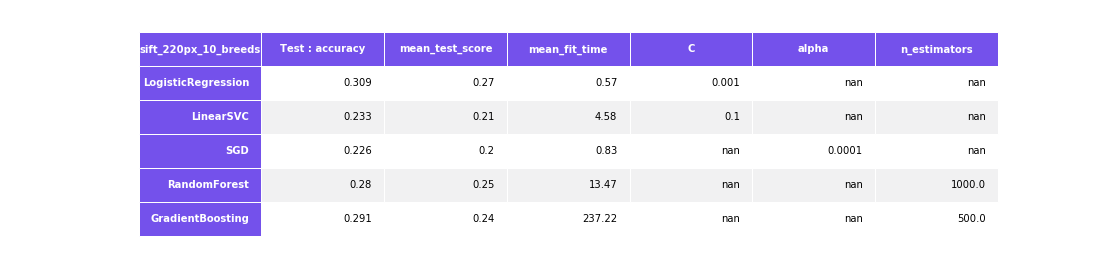

Wall time: 11min 27s


In [10]:
k = 300
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
%time kmeans.fit(descriptor_list)

%time bovw_train = get_vector_sift(X_train, kmeans, k)
%time bovw_test = get_vector_sift(X_test, kmeans, k)


classifiers = [('LogisticRegression',
                LogisticRegression(),
                [{'C': [0.001, 0.1, 1]}]),

              ('LinearSVC',
               LinearSVC(),
               [{'C': [00.1, 0.1, 1]}]), 

              ('SGD',
               SGDClassifier(),
               [{'alpha': [10**-6, 10**-5, 10**-4]}]),
               
              ('RandomForest',
               RandomForestClassifier(random_state=123),
               [{'n_estimators': [200, 500, 1000]}]),

              ('GradientBoosting', 
               GradientBoostingClassifier(random_state=123), 
               [{'n_estimators': [200, 500, 1000]}])]

%time evaluate_classifier(bovw_train, bovw_test, y_train, y_test, classifiers, target_name='sift_' + str(size_image) + '_' + str(n_breeds) + '_breeds')

Choix du modèle : Régression logistique

In [ ]:
model = LogisticRegression(C=0.001, n_jobs=-1)
model.fit(bovw_train, y_train)
y_pred = model.predict(bovw_test)


cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Matrice de confusion pour ' + str(size_image) + ' ' + str(n_breeds) + ' races')
plt.savefig('img/sift_confusion_matrix_' + str(size_image) + '_' + str(n_breeds) + '_breeds.png',
            transparent=True,
            bbox_inches="tight")

---
# 8. Conclusion
Je perd en précision au fur et à mesure que j'ajoute des races au modèle.
Plus le nombre de classes augmente, plus la précision diminue. Il faut voir du coté d'une autre technologie pour prédire 120 races.